# Resource analysis description

The purpose of this analysis is to measure resource usage of the implemented methods. Due to memory usage monitor being available from Tensorflow 2.4+ resulting in memory usage not being available for Python process, we have decided to measure time complexity of methods with respect to the number of nodes, edges and output dimension.

# Setup

In [9]:
import os
os.chdir("..")
import networkx as nx
import numpy as np
import relegy.embeddings as rle
import relegy.graphs as rlg
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import contextlib
from tqdm import tqdm
import warnings
from matplotlib.pylab import rcParams
import pickle
os.chdir("Analysis")
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [10]:
# profiler
# profile.py
import time
import os
import psutil
import inspect
import gc


def elapsed_since(start):
    #return time.strftime("%H:%M:%S", time.gmtime(time.time() - start))
    elapsed = time.time() - start
    if elapsed < 1:
        return str(round(elapsed*1000,2)) + "ms", elapsed
    if elapsed < 60:
        return str(round(elapsed, 2)) + "s", elapsed
    if elapsed < 3600:
        return str(round(elapsed/60, 2)) + "min", elapsed
    else:
        return str(round(elapsed / 3600, 2)) + "hrs", elapsed


def get_process_memory():
    process = psutil.Process(os.getpid())
    mi = process.memory_info()
    return mi.rss, mi.vms


def format_bytes(bytes):
    if abs(bytes) < 1000:
        return str(bytes)+"B"
    elif abs(bytes) < 1e6:
        return str(round(bytes/1e3,2)) + "kB"
    elif abs(bytes) < 1e9:
        return str(round(bytes / 1e6, 2)) + "MB"
    else:
        return str(round(bytes / 1e9, 2)) + "GB"


def profile(func, *args, **kwargs):
    global profiling_results
    gc.collect()
    time.sleep(5)
    def wrapper(*args, **kwargs):
        gc.disable()
        rss_before, vms_before = get_process_memory()
        start = time.time()
        result = func(*args, **kwargs)
        elapsed_time, elapsed_time_raw = elapsed_since(start)
        rss_after, vms_after = get_process_memory()
        profiling_results[-1].append((rss_after - rss_before, vms_after - vms_before, elapsed_time, elapsed_time_raw))
        profiling_results[-1].append("RSS: {:>8} | VMS: {:>8} | time: {:>8}"
            .format(format_bytes(rss_after - rss_before),
                    format_bytes(vms_after - vms_before),
                    elapsed_time))
        gc.enable()
        return result
    if inspect.isfunction(func):
        return wrapper
    elif inspect.ismethod(func):
        return wrapper(*args,**kwargs)
    
@profile
def profile_method(method_class, **kwargs):
    global profiling_results
    profiling_results.append([])
    profiling_results[-1].append(method_class)
    method_class.fast_embed(**kwargs)

# Measure time with respect to the number of nodes - 50-400

In [4]:
warnings.filterwarnings("ignore")
methods = [(method_name, method_class) for method_name, method_class in inspect.getmembers(rle) if method_name not in ("GCN", "GNN", "__builtins__")][:12]
graph_sizes = list(range(50,450,50))
graphs_with_labels = [rlg.generate_clusters_graph(graph_size, 5, 0.03, 0.95) for graph_size in graph_sizes]
iterations = 10
for i in range(iterations):
    result_dict_nodes = {}
    for graph, labels in graphs_with_labels:
        graph_size = len(graph.nodes)
        print(f"Graph size: {graph_size}")
        profiling_results = []
        for method_name,method_class in tqdm(methods):
            with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
                profile_method(method_class, graph=graph)

        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            profile_method(rle.GCN, graph=graph, Y=labels)

        labelsGNN = np.array([np.arange(len(labels)),labels]).T
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            profile_method(rle.GNN, graph=graph, idx_labels=labelsGNN)

        result_dict_nodes[graph_size]=profiling_results
    with open(f"Resource/time_analysis_results_nodes-{i}.p","wb") as f:
        pickle.dump(result_dict_nodes, f)

  0%|          | 0/12 [00:00<?, ?it/s]

Graph size: 50


  0%|          | 0/12 [00:02<?, ?it/s]


KeyboardInterrupt: 

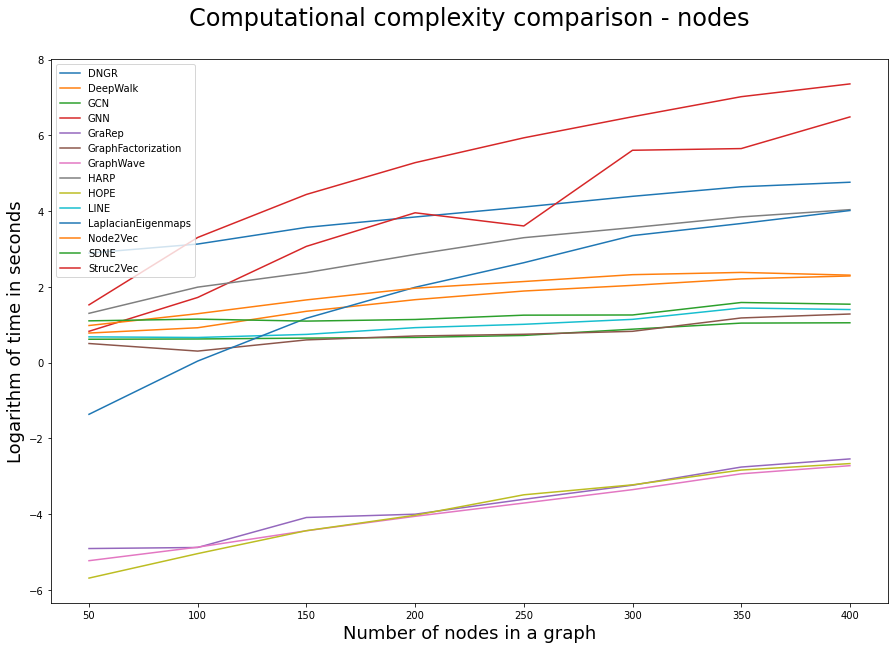

In [17]:
rcParams["figure.figsize"] = 15, 10

iterations = 10
result_dict_nodes_loaded = [None]*iterations
for i in range(iterations):
    with open(f"Resource/time_analysis_results_nodes.p","rb") as f:
        result_dict_nodes_loaded[i] = pickle.load(f)

method_result_dict = {method_class:{} for method_name, method_class in inspect.getmembers(rle)[:14]}
for result_dict in result_dict_nodes_loaded:
    for key, values in result_dict.items():
        for method_class, measures, _ in values:
            if key in method_result_dict[method_class]:
                method_result_dict[method_class][key] += measures[3]
            else:
                method_result_dict[method_class][key] = measures[3]
        
for method in method_result_dict.keys():
    for key in method_result_dict[method].keys():
        method_result_dict[method][key] /= iterations
        

for i in method_result_dict.keys():
    curv = np.array(list(method_result_dict[i].items()))
    name = str(i).split(".")[3]
    name = name.split("'")[0]
    plt.plot(curv[:, 0], np.log(curv[:, 1]), label=name)
plt.legend()
plt.title("Computational complexity comparison - nodes\n", fontsize=24)
plt.xlabel("Number of nodes in a graph",  fontsize=18)
plt.ylabel("Logarithm of time in seconds",  fontsize=18)
plt.savefig("Resource/time-nodes.png", transparent=True)
plt.show()

# Measure time with respect to the number of edges

In [36]:
warnings.filterwarnings("ignore")
between_cluster_probablities = list(map(lambda x: x/100, range(2, 30, 4)))
graphs_with_labels = [rlg.generate_clusters_graph(120, 5, bcp, 0.5) for bcp in between_cluster_probablities]
methods = [(method_name, method_class) for method_name, method_class in inspect.getmembers(rle) if method_name not in ("GCN", "GNN", "__builtins__")][:12]

iterations = 10

for i in range(iterations):
    result_dict_edges = {}
    for graph, labels in graphs_with_labels:
        n_edges = len(graph.edges)
        print(f"Number of edges: {n_edges}")
        profiling_results = []
        for method_name,method_class in tqdm(methods):
            with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
                profile_method(method_class, graph=graph)

        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            profile_method(rle.GCN, graph=graph, Y=labels)

        labelsGNN = np.array([np.arange(len(labels)),labels]).T
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            profile_method(rle.GNN, graph=graph, idx_labels=labelsGNN)

        result_dict_edges[n_edges]=profiling_results
    with open(f"Resource/time_analysis_results_edges-{i}.p","wb") as f:
        pickle.dump(result_dict_edges, f)

  0%|          | 0/12 [00:00<?, ?it/s]

Number of edges: 1423


  0%|          | 0/12 [00:00<?, ?it/s]

Number of edges: 1665


  0%|          | 0/12 [00:00<?, ?it/s]

Number of edges: 1423


  0%|          | 0/12 [00:00<?, ?it/s]

Number of edges: 1665


100%|██████████| 12/12 [01:36<00:00,  8.03s/it]


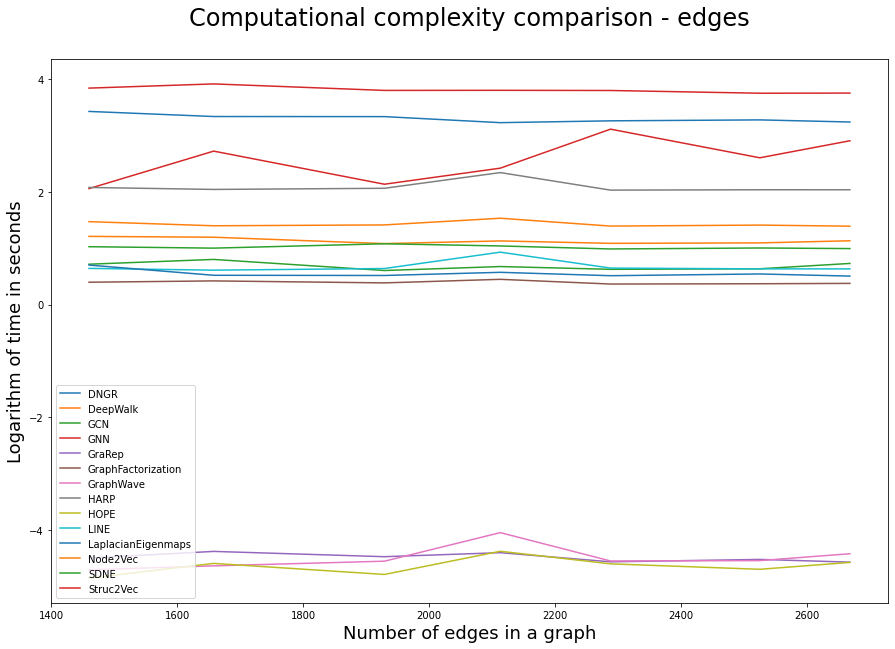

In [14]:
rcParams["figure.figsize"] = 15, 10

iterations = 10
result_dict_edges_loaded = [None]*iterations
for i in range(iterations):
    with open(f"Resource/time_analysis_results_edges-{i}.p","rb") as f:
        result_dict_edges_loaded[i] = pickle.load(f)

method_result_dict = {method_class:{} for method_name, method_class in inspect.getmembers(rle)[:14]}
for result_dict in result_dict_edges_loaded:
    for key, values in result_dict.items():
        for method_class, measures, _ in values:
            if key in method_result_dict[method_class]:
                method_result_dict[method_class][key] += measures[3]
            else:
                method_result_dict[method_class][key] = measures[3]
        
for method in method_result_dict.keys():
    for key in method_result_dict[method].keys():
        method_result_dict[method][key] /= iterations

for i in method_result_dict.keys():
    curv = np.array(list(method_result_dict[i].items()))
    name = str(i).split(".")[3]
    name = name.split("'")[0]
    plt.plot(curv[:, 0], np.log(curv[:, 1]), label=name)
plt.legend()
plt.title("Computational complexity comparison - edges\n", fontsize=24)
plt.xlabel("Number of edges in a graph",  fontsize=18)
plt.ylabel("Logarithm of time in seconds",  fontsize=18)
plt.savefig("Resource/time-edges.png", transparent = True)
plt.show()

# Measure time with respect to the output dimension - 2-18

In [49]:
warnings.filterwarnings("ignore")
methods = [(method_name, method_class) for method_name, method_class in inspect.getmembers(rle) if method_name not in ("GCN", "GNN", "__builtins__")][:12]
output_dimensions = list(range(2, 20, 2))
graph, labels = rlg.generate_clusters_graph(90, 5, 0.03, 0.95)
iterations = 10

for i in range(iterations):
    result_dict_dimension = {}
    for d in output_dimensions:
        print(f"Output dimenson: {d}")
        profiling_results = []
        for method_name,method_class in tqdm(methods):
            with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
                if name in ["GraphWave", "HOPE", "LINE"]:
                    current_d = d // 2
                else:
                    current_d = d
                profile_method(method_class, graph=graph, d=current_d)

        labelsGNN = np.array([np.arange(len(labels)),labels]).T
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            profile_method(rle.GNN, graph=graph, idx_labels=labelsGNN, embed_dim=d)

        result_dict_dimension[d]=profiling_results
    with open(f"Resource/time_analysis_results_dimension-{i}.p","wb") as f:
        pickle.dump(result_dict_dimension, f)

  0%|          | 0/12 [00:00<?, ?it/s]

Output dimenson: 2


  0%|          | 0/12 [00:00<?, ?it/s]

Output dimenson: 4


  0%|          | 0/12 [00:00<?, ?it/s]

Output dimenson: 2


  0%|          | 0/12 [00:00<?, ?it/s]

Output dimenson: 4


100%|██████████| 12/12 [01:05<00:00,  5.46s/it]


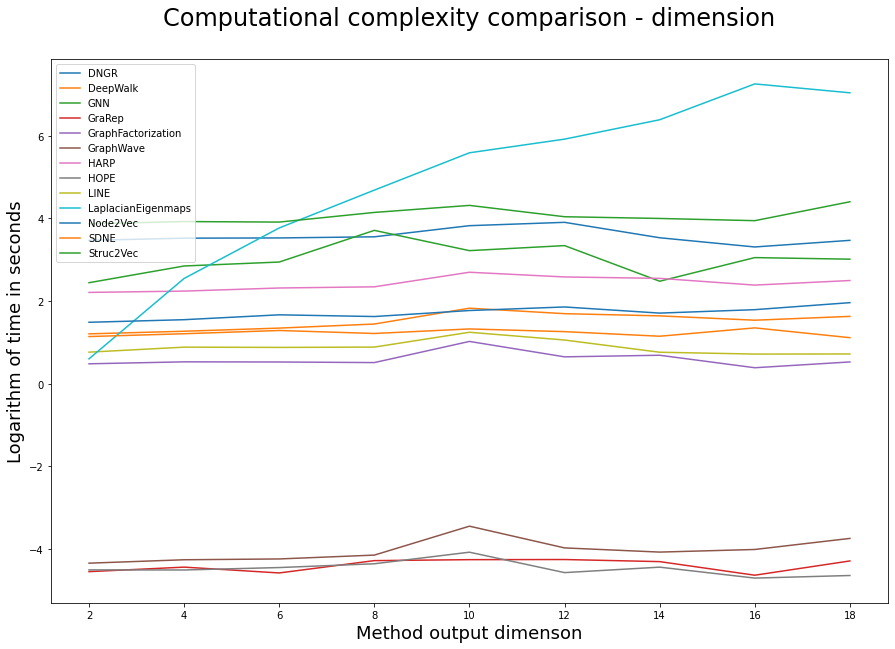

In [19]:
rcParams["figure.figsize"] = 15, 10

iterations = 10
result_dict_dimension_loaded = [None]*iterations
for i in range(iterations):
    with open(f"Resource/time_analysis_results_dimension-{i}.p","rb") as f:
        result_dict_dimension_loaded[i] = pickle.load(f)

method_result_dict = {method_class:{} for method_name, method_class in inspect.getmembers(rle)[:14]}
for result_dict in result_dict_dimension_loaded:
    for key, values in result_dict.items():
        for method_class, measures, _ in values:
            if key in method_result_dict[method_class]:
                method_result_dict[method_class][key] += measures[3]
            else:
                method_result_dict[method_class][key] = measures[3]

for method in method_result_dict.keys():
    for key in method_result_dict[method].keys():
        method_result_dict[method][key] /= iterations
                
for i in method_result_dict.keys():
    curv = np.array(list(method_result_dict[i].items()))
    name = str(i).split(".")[3]
    name = name.split("'")[0]
    if name != "GCN":
        plt.plot(curv[:, 0], np.log(curv[:, 1]), label=name)
plt.legend()
plt.title("Computational complexity comparison - dimension\n", fontsize=24)
plt.xlabel("Method output dimenson",  fontsize=18)
plt.ylabel("Logarithm of time in seconds",  fontsize=18)
plt.savefig("Resource/time-dimension.png", transparent = True)
plt.show()

# Measure Time and Python/TF2.4 memory usage (future purpose)

In [ ]:
import os, sys
import contextlib

graph, labels = rlg.generate_clusters_graph(200, 5, 0.03, 0.95)
methods = [(method_name, method_class) for method_name, method_class in inspect.getmembers(rle) if method_name not in ("GCN", "GNN", "__builtins__")][:12]
profiling_results = []
for method_name,method_class in methods:
    if isTFMethod[method_name]:
        initial_mem_usage = tf.config.experimental.get_memory_usage()
        print(f"Profiling {method_name} (TF)")
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            profile_method(method_class, graph=graph)
        final_memory_usage = tf.config.experimental.get_memory_usage()
        mu_diff = final_memory_usage - initial_mem_usage
        profiling_results[-1].append(("TF Memory usage", 
                                      mu_diff, 
                                      format_bytes(mu_diff)))
    else:
        print(f"Profiling {method_name} (TF)")
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            profile_method(method_class, graph=graph)

initial_mem_usage = tf.config.experimental.get_memory_usage()
print(f"Profiling GCN")
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    profile_method(rle.GCN, graph=graph, Y=labels)
final_memory_usage = tf.config.experimental.get_memory_usage()
        mu_diff = final_memory_usage - initial_mem_usage
        profiling_results[-1].append(("TF Memory usage", 
                                      mu_diff, 
                                      format_bytes(mu_diff)))
        
labelsGNN = np.array([np.arange(len(labels)),labels]).T
initial_mem_usage = tf.config.experimental.get_memory_usage()
print(f"Profiling GNN")
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    profile_method(rle.GCN, graph=graph, Y=labelsGNN)
final_memory_usage = tf.config.experimental.get_memory_usage()
mu_diff = final_memory_usage - initial_mem_usage
profiling_results[-1].append(("TF Memory usage", 
                              mu_diff, 
                              format_bytes(mu_diff)))

In [89]:
profiling_results

[[relegy.embeddings.DNGR.DNGR,
  (2928640, 3268608, '48.85s', 48.84972786903381),
  'RSS:   2.93MB | VMS:   3.27MB | time:   48.85s'],
 [relegy.embeddings.DeepWalk.DeepWalk,
  (19689472, 19738624, '5.19s', 5.185544013977051),
  'RSS:  19.69MB | VMS:  19.74MB | time:    5.19s'],
 [relegy.embeddings.GraRep.GraRep,
  (-18100224, -18120704, '27.65ms', 0.027652263641357422),
  'RSS:  -18.1MB | VMS: -18.12MB | time:  27.65ms'],
 [relegy.embeddings.GraphFactorization.GraphFactorization,
  (32768, 0, '1.98s', 1.9834721088409424),
  'RSS:  32.77kB | VMS:       0B | time:    1.98s'],
 [relegy.embeddings.GraphWave.GraphWave,
  (-1425408, -1380352, '31.12ms', 0.03112030029296875),
  'RSS:  -1.43MB | VMS:  -1.38MB | time:  31.12ms'],
 [relegy.embeddings.HARP.HARP,
  (19386368, 19357696, '16.88s', 16.88197898864746),
  'RSS:  19.39MB | VMS:  19.36MB | time:   16.88s'],
 [relegy.embeddings.HOPE.HOPE,
  (-18169856, -18186240, '25.31ms', 0.02531290054321289),
  'RSS: -18.17MB | VMS: -18.19MB | time:  2

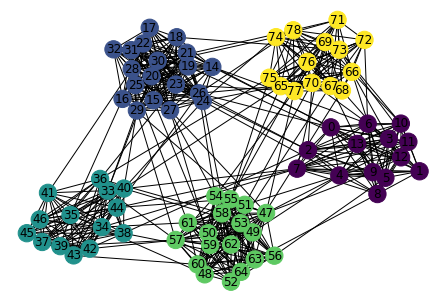

In [34]:
nx.draw(graph, with_labels=True, node_color=labels)